# Load dataset

In [46]:
from collections import defaultdict
import pickle
import numpy as np

class NestedDict(defaultdict):
    def __init__(self):
        super().__init__(self.__class__)
    def __reduce__(self):
        return (type(self), (), None, None, iter(self.items()))
    
with open("../../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

2524


In [47]:
iso = np.array([dataset["sws"][k]["iso"] for k in slow_wave_ids])
starts = np.array([dataset["sws"][k]["start"] for k in slow_wave_ids])
stops = np.array([dataset["sws"][k]["stop"] for k in slow_wave_ids])
width = np.array([dataset["sws"][k]["width"] for k in slow_wave_ids])
height = np.array([dataset["sws"][k]["height"] for k in slow_wave_ids])
gcamp = np.array([dataset["sws"][k]["gcamp_interpolated"] for k in slow_wave_ids])
hemo = np.array([dataset["sws"][k]["hemo_interpolated"] for k in slow_wave_ids])
#gcamp = np.array([dataset["sws"][k]["gcamp_mean_centered"] for k in slow_wave_ids])
#hemo = np.array([dataset["sws"][k]["hemo_mean_centered"] for k in slow_wave_ids])

In [48]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size=.2
batch_size = 100
x_train, x_test = train_test_split(gcamp, test_size=test_size, random_state = random_state)

In [49]:
x_train.shape

(2019, 128)

In [50]:
image_size = x_train.shape[1]
original_dim = 128

# Variational Autoenconder

In [51]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [52]:
def get_vae_loss(inputs, outputs, z_mean, z_log_var, reconstruction_loss = "mse", original_dim = 130):
    # VAE loss = mse_loss or binary_crossentropy + kl_loss
    if reconstruction_loss == "binary_crossentropy":
        reconstruction_loss = binary_crossentropy(inputs,outputs)
    elif reconstruction_loss == "mse":
        reconstruction_loss = mse(inputs, outputs)

    reconstruction_loss *= original_dim
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss

In [87]:
## network parameters
input_shape = (128, )
original_dim = input_shape[0]
batch_size = 100
epochs = 250

In [88]:
def mlp_encoder(input_shape, latent_dim = 2, intermediate_dim = 512, layers = 2):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for l in range(layers):
        x = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return inputs, [z_mean, z_log_var, z]

In [89]:
def mlp_decoder(original_dim, latent_dim = 2, intermediate_dim = 512, layers = 2):
    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = latent_inputs
    for l in range(layers):
        x = Dense(intermediate_dim, activation='relu')(x)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    return latent_inputs, outputs

In [90]:
# VAE model
inputs, [z_mean, z_log_var, z] = mlp_encoder(input_shape)
latent_inputs, outputs = mlp_decoder(original_dim)
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# Add loss and compile
vae.add_loss(get_vae_loss(inputs, outputs, z_mean, z_log_var))
vae.compile(optimizer='adam')

In [91]:
# train the autoencoder
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None), verbose=0)

# Visualize results

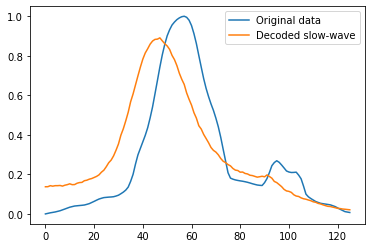

In [500]:
i = 100
res = vae.predict(x_train[i:i+1])
plt.plot(x_train[i][:-2], label="Original data")
plt.plot(res[0][:-2], label="Decoded slow-wave")
plt.legend()

In [486]:
x_test_latent = encoder.predict(x_test)
x, y = x_test_latent[2].T

In [488]:
#x,y = remove_outliers([x,y],1.5)

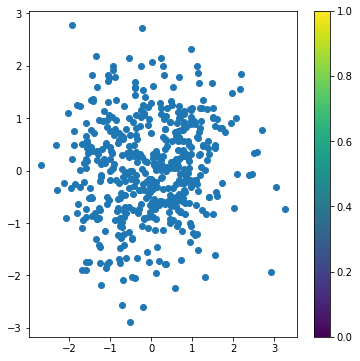

In [489]:
# Plot of the digit classes in the latent space
plt.figure(figsize=(6, 6))
#plt.scatter(x_test_latent[0], x_test_latent[1])#, c=test_labels)
plt.scatter(x, y)
plt.colorbar()
plt.show()

In [490]:
x_min, x_max = [np.min(x),np.max(x)]
y_min, y_max = [np.min(y),np.max(y)]

In [491]:
x_min

-2.684575

In [492]:
latent = np.array(([list([x[0]]) for x in encoder.predict(x_train[1:2])]))

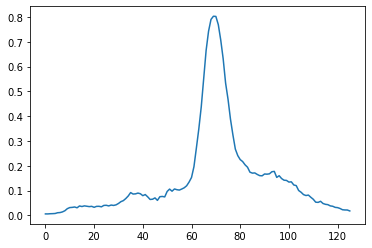

In [493]:
plt.plot(decoder.predict(latent)[1][0][:-2])

In [494]:
np.array([latent[0]])

array([[[ 0.85959864, -0.8263899 ]]], dtype=float32)

In [495]:
def fig2rgb_array(fig):
    """ Converts a matplotlib figure to an rgb array such that it may be displayed as an ImageDisplay
    Args:
        fig: Matplotlib figure
    Returns:
        arr: Image of the plot in the form of a numpy array
    """
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

def manifold(decoder, x_range = [-2,2], y_range = [-0.5, -2.5], n = 10, figsize=(8,8), dpi = 200):
    x = np.linspace(x_range[0], x_range[1], n)
    y = np.linspace(y_range[0], y_range[1], n)
    m = np.array(np.meshgrid(y, x)).T
    
    predictions = np.ndarray((m.shape[0], m.shape[1]), dtype=np.ndarray)
    for y in range(predictions.shape[0]):
        for x in range(predictions.shape[1]):
            predictions[y,x] = decoder.predict(np.array([[m[y,x]]], dtype=np.float32)).flatten()
    fig, ax = plt.subplots(n, n, figsize= figsize, dpi = dpi)
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    for y in range(predictions.shape[0]):
        for x in range(predictions.shape[1]):
            ax[y,x].plot(predictions[y, x])
            ax[y,x].axis("off")
    return fig2rgb_array(fig)
            
            

In [496]:
%%capture
res = manifold(decoder, x_range = [x_min, x_max], y_range = [y_min,y_max], n=15)

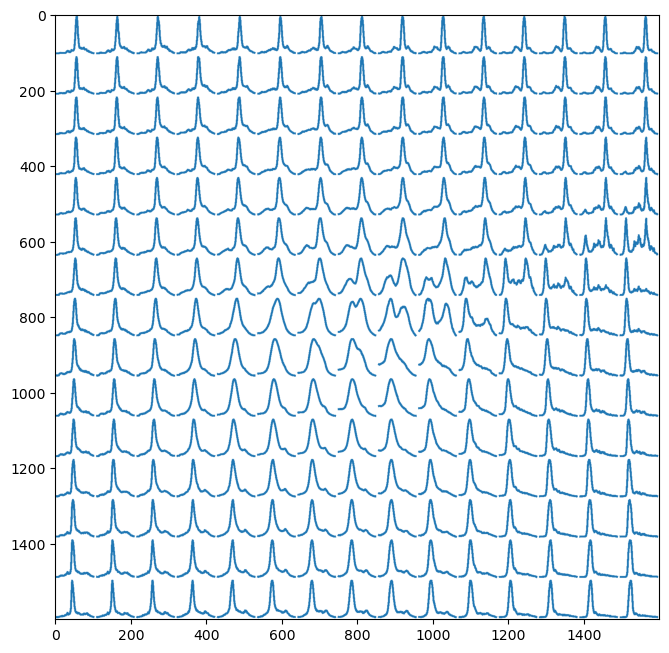

In [497]:
fig, ax = plt.subplots(1, figsize= (8,8), dpi=100)
ax.imshow(res)

In [468]:
def remove_outliers(vectors, m=2):
    vectors = np.array(vectors)
    indices = []
    for data in vectors:
        idx = np.where((abs(data - np.mean(data)) < m * np.std(data)))[0]
        indices.extend(idx)
    indices = np.array(indices).flatten()
    indices = list(set(indices))
    print(len(indices)/len(vectors[0]))
    return vectors[:,indices]